# overview
20231119
sarahfong


**Goal** - design liver MPRA for Ajam specific accessible regions in Ajam2 genome sequences


**Design features**

- Ajam-specific liver accessible sequences from Ajam v. EptFus atac-seq (N = 2218 loci), 
    - compared by liftingOver both atac-regions to hg38, require only 10% identity. 
    - Then, lifted sequences back to Ajam2 genome build
    
- Tiles: 200bp long tiles

- Step size: 20bp-step sliding window across loci

- Shuffle: 300 dinucleotide shuffled elements randomly sampled from 2218 test loci

- Controls: 350 HepG2 Synthetic positive (N=181) and negative (N=169) controls from Smith 2013

- GC fraction: filter for 40-60% GC content

- Reverse complement: assuming everything lifted from Hg38 to Ajam2 is in the forward position, so I will also make the reverse position


## results
    Library_forward: N = 53298 or 52698 tiles + 300 shuffle + 350 positive/negative controls
    Library_forward GC filtered = 23182 tiles or 22567 tiles + 300 shuffle + 315 positive/negative controls
    
    Library_reverse: N = 53298 or 52698 tiles + 300 shuffle + 350 positive/negative controls
    Library_reverse GC filtered = 23182 tiles or 22567 tiles + 300 shuffle + 315 positive/negative controls

In [25]:
from Bio.SeqIO.FastaIO import SimpleFastaParser
from Bio.Seq import reverse_complement, Seq
from Bio.SeqUtils import gc_fraction

import os, sys
import numpy as np
import pandas as pd
#import pybedtools as pbt
from random import shuffle
import matplotlib.pyplot as plt
import seaborn as sns

import config_readwrite as crw
import plot_params as pp
pp.fonts()

('sans-serif', 'Arial', 18)

# config and params

In [2]:
cfn_file = os.path.join(os.getcwd(), "config.bat2.ini")

config, cfn = crw.read(cfn_file)

## dataset params

In [3]:
# dataset params
TISSUE = "liver"
SPECIES = "ajam"
BUILD = "artjam2"
PATH =  config[TISSUE][f"{SPECIES}_path"]

LIVER_FASTA = config[TISSUE][f'{TISSUE}.{SPECIES}_specific.{BUILD}.fa']

## mpra params

In [4]:
# mpra params
TILE_LEN = 200
STEP = 20
N_SHUF = 300  # number of randomly selected sequences to shuffle
GC_CONTENT_MIN = 0.4 # min fraction of GC content in the sequence
GC_CONTENT_MAX = 0.6 # max fraction of GC concent in the sequence
REVERSE = True  # bool, do you want reverse complement of sequence?

TEST = os.path.join(PATH, f"mpra.{TISSUE}.{SPECIES}_specific.wo.adapters.fa")
SHUFFLE = os.path.join(PATH, f"mpra.{TISSUE}.{SPECIES}_specific.wo.adapters.shuffle.fa")
META = os.path.join(PATH, f"mpra.{TISSUE}.{SPECIES}_specific.meta.txt")

## positive and negative controls

In [5]:
CTRL_PATH = "/wynton/group/ahituv/fongsl/projects/MPRA_DESIGN/data/"
NEG_HEPG2_SYN = os.path.join(CTRL_PATH, "HepG2.negative.ctrl.noadapters.fa")
POS_HEPG2_SYN = os.path.join(CTRL_PATH, "HepG2.positive.ctrl.noadapters.fa")

In [6]:
section = "mpra"
crw.check(config, section)

config[section]["test_sequences"] = TEST
config[section]["shuffled_sequences"] = SHUFFLE
config[section]["tile_len"] = str(TILE_LEN)
config[section]["step_size"] = str(STEP)

config[section]["n_shuffles"] = str(N_SHUF)
config[section]["gc_content_min"] = str(GC_CONTENT_MIN)
config[section]["gc_content_max"] = str(GC_CONTENT_MAX)
config[section]["reverse_orientation"] = str(REVERSE)

# functions

In [7]:
def makeTile(seq, start_index, size):
    """return sequence slice from start to start+size"""

    start_index, size = int(start_index), int(size)
    stop_index = int(start_index) + size
    tile_sequence = seq[start_index:stop_index]

    if len(tile_sequence) != size:  # check if tile sequence is too short.
        tile_sequence = None

    return tile_sequence


def addAdaptors(tile_sequence):
    """add illumina adaptors to left and right of sequence"""

    adaptor5, adaptor3 = "AGGACCGGATCAACT", "CATTGCGTGAACCGA"
    adapted = adaptor5 + seq + adaptor3

    return adapted.upper()


def dinucScramble(seq, verbose):
    """dinucleotide scramble sequences"""

    n = 2  # pick size 2

    # split sequence into pairs
    splits = [seq[i:i+n] for i in range(0, len(seq), n)]
    shuf_splits = splits[::]

    shuffle(shuf_splits)  # from random library

    if verbose is True:
        print(np.unique(splits, return_counts=True))
        print(np.unique(shuf_splits, return_counts=True))

    return "".join(shuf_splits)


def checkLength(name, seq, tile_length):
    """check that sequence is the correct length in the dataframe"""

    
    if len(seq) != tile_length:
        
        print("length is wrong for", name,
              "\nactual lengh:", len(seq),
              "\ndesired length:", tile_length)
        return False
    else:
        return True

def writeFaDict(dict_, outfile):
    """write dictionary to fasta file"""

    # open the file
    with open(outfile, "w") as writer:

        # parse dictionary
        for name, seq in dict_.items():

            # add '>' if not in name
            if ">" not in name:
                print("add > to", name)
                name = ">" + name

            # write line
            writer.write(f"{name}\n{seq}\n")

# parse fasta

In [8]:
tile_dict = {} # dictionary to collect tiles
gc_dict={}  # dictionary to collect gc content info

with open(LIVER_FASTA, "r") as fa:  # open fasta
    for value in SimpleFastaParser(fa):  # parse fasta
        
        name, sequence = value  # get sequence data
        n_steps = 0
        
        # make tiles with step
        for step in np.arange(0, len(sequence), STEP): 
            
            # get tile sequence
            tile = makeTile(sequence, step, TILE_LEN)
            
            # add to dictionary
            if tile is not None:  # if None, tile exceeds end of sequence
                # compute the GC fraction
                gc_frac= int(gc_fraction(tile)*100)
            
                # name tile
                tilename = f">{name}.tile_{n_steps}.{BUILD}.{gc_frac}"
                
                # add tile to dictionary
                tile_dict[tilename] = tile
                gc_dict[tilename]=gc_fraction(tile)
            
            # increase step counter
            n_steps +=1

In [9]:
print(len(tile_dict.keys()))

52698


## inspect GC content

In [ ]:
gc = pd.DataFrame(gc_dict.items(),columns=["name", "gc_frac"])
gc_filter = gc.loc[(gc["gc_frac"] >= GC_CONTENT_MIN)
                         & (gc["gc_frac"] <= GC_CONTENT_MAX)]

### plot GC fraction

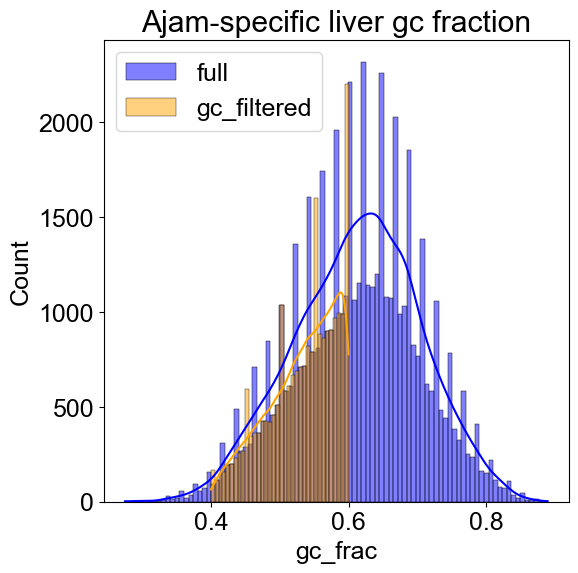

In [28]:
fig, ax=plt.subplots(figsize=(6,6))
sns.histplot(x="gc_frac", data=gc, color="blue", label="full", kde=True)
sns.histplot(x="gc_frac", data=gc_filter, color="orange", label="gc_filtered", kde=True)
ax.legend()

ax.set(title="Ajam-specific liver gc fraction")
plt.savefig(os.path.join(PATH, f"{TISSUE}.{SPECIES}_specific.gc_content.pdf"), bbox_inches="tight")

## filter GC? 

In [11]:
gc_filtered = set(gc.loc[(gc["gc_frac"] >= GC_CONTENT_MIN)
                         & (gc["gc_frac"] <= GC_CONTENT_MAX),
                         "name"]
                  )
print("after GC filtering, N tiles meet this criteria",
      len(gc_filtered),
      "\n% of all tiles",
      len(gc_filtered)/gc.shape[0])

after GC filtering, N tiles meet this criteria 22567 
% of all tiles 0.428232570496034


# dinucleotide shuffles

In [12]:
# sample tiles without replacement
random_selected = np.random.choice(list(tile_dict.keys()),
                                   size=N_SHUF,
                                   replace=False
                                   )  


shuf_dict = {}  # random shuffle dictionary

# shuffle random tiles
for n, tile_id in enumerate(random_selected):
    
    tile_seq = tile_dict[tile_id]  # get tile sequence
    
    # shuffle tile sequence
    tile_scram = dinucScramble(tile_seq, True if n ==0 else False)

    # make shuffled id
    shuf_id = tile_id + ".shuffle" 
    shuf_dict[shuf_id]= tile_scram

(array(['AC', 'AG', 'AT', 'CA', 'CC', 'CG', 'CT', 'GA', 'GC', 'GG', 'GT',
       'Ga', 'TA', 'TC', 'TG', 'TT', 'aa', 'cc', 'ct', 'gg', 'tc', 'tt'],
      dtype='<U2'), array([ 1, 13,  1, 12,  7,  1,  6,  6,  9,  9,  3,  1,  3,  7,  9,  2,  1,
        5,  1,  1,  1,  1]))
(array(['AC', 'AG', 'AT', 'CA', 'CC', 'CG', 'CT', 'GA', 'GC', 'GG', 'GT',
       'Ga', 'TA', 'TC', 'TG', 'TT', 'aa', 'cc', 'ct', 'gg', 'tc', 'tt'],
      dtype='<U2'), array([ 1, 13,  1, 12,  7,  1,  6,  6,  9,  9,  3,  1,  3,  7,  9,  2,  1,
        5,  1,  1,  1,  1]))


## shuffle random tiles - GC filtered

In [13]:
shuf_gc = {}

random_selected_gc = np.random.choice(list(gc_filtered),
                                      size=N_SHUF,
                                      replace=False
                                      )
for n, tile_id in enumerate(random_selected_gc):

    tile_seq = tile_dict[tile_id]  # get tile sequence

    # shuffle tile sequence
    tile_scram = dinucScramble(tile_seq, True if n == 0 else False)

    # make shuffled id
    shuf_id = tile_id + ".shuffle"
    shuf_gc[shuf_id] = tile_scram

(array(['AA', 'AC', 'AG', 'AT', 'CA', 'CC', 'CG', 'CT', 'GA', 'GC', 'GG',
       'TA', 'TC', 'TG', 'TT', 'aC', 'ac', 'cc', 'cg', 'ct', 'gc', 'ta'],
      dtype='<U2'), array([ 5,  3, 11,  2,  5,  7,  3,  6,  4,  7, 10,  3,  8,  5,  6,  1,  2,
        8,  1,  1,  1,  1]))
(array(['AA', 'AC', 'AG', 'AT', 'CA', 'CC', 'CG', 'CT', 'GA', 'GC', 'GG',
       'TA', 'TC', 'TG', 'TT', 'aC', 'ac', 'cc', 'cg', 'ct', 'gc', 'ta'],
      dtype='<U2'), array([ 5,  3, 11,  2,  5,  7,  3,  6,  4,  7, 10,  3,  8,  5,  6,  1,  2,
        8,  1,  1,  1,  1]))


# positive, negative controls

## negative control dictionary

In [14]:
neg_control = {}
with open(NEG_HEPG2_SYN, "r") as reader:
    for value in SimpleFastaParser(reader):
        name, seq = value
        neg_control[name] = seq

## positive control dictionary

In [15]:
pos_control = {}
with open(POS_HEPG2_SYN, "r") as reader:
    for value in SimpleFastaParser(reader):
        name, seq = value
        pos_control[name] = seq

# combine sets, add adaptors

In [16]:
library, library_gc = {}, {}
dicts = [tile_dict, shuf_dict, neg_control, pos_control]
for d in dicts:
    for k, v in d.items():  # d.items() in Python 3+

        # I'm assuming everything is in the forward direction from the hg38 genome build
        k_plus = k + ".+"

        # check sequence length before adding adaptors
        length_check = checkLength(k, v, TILE_LEN)

        if length_check is True:

            # add adaptors
            library[k_plus] = addAdaptors(v)

            # filter gc content
            if k in gc_filtered:
                library_gc[k_plus] = addAdaptors(v)

            # add filtered positive and negative controls in
            elif "Smith" in k:
                # get GC fraction
                gc_frac = int(k.split(".")[-1])/100

                if gc_frac >= GC_CONTENT_MIN and gc_frac <= GC_CONTENT_MAX:
                    library_gc[k_plus] = addAdaptors(v)

# add shuffled GC_filtered elements to GC filtered dataset
for k, v in shuf_gc.items():
    # I'm assuming everything is in the forward direction from the hg38 genome build
    k_plus = k + ".+"

    # check sequence length before adding adaptors
    length_check = checkLength(k, v, TILE_LEN)

    if length_check is True:
        library_gc[k_plus] = addAdaptors(v)
print(len(library.keys()), len(library_gc.keys()))

53348 23182


## reverse complement? 

In [17]:
library_rev, library_rev_gc = {}, {}  # collect results

dicts = [tile_dict, shuf_dict, neg_control, pos_control]

for d in dicts:
    for k, v in d.items():  # d.items() in Python 3+

        # I'm assuming everything is in the forward direction from the hg38 genome build
        k_minus = k + ".-"

        rev_v = reverse_complement(v)  # get reverse complement of sequence

        # check sequence length before adding adaptors
        length_check = checkLength(k, v, TILE_LEN)

        if length_check is True:
            # add adaptors
            library_rev[k_minus] = addAdaptors(rev_v)

            # filter gc content
            if k in gc_filtered:
                library_rev_gc[k_minus] = addAdaptors(rev_v)

            # add filtered positive and negative controls in
            elif "Smith" in k:
                # get GC fraction
                gc_frac = int(k.split(".")[-1])/100

                if gc_frac >= GC_CONTENT_MIN and gc_frac <= GC_CONTENT_MAX:
                    library_rev_gc[k_minus] = addAdaptors(rev_v)

# add shuffled GC_filtered elements to GC filtered dataset
for k, v in shuf_gc.items():

    # I'm assuming everything is in the forward direction from the hg38 genome build
    k_minus = k + ".-"

    rev_v = reverse_complement(v)  # get reverse complement of sequence

    # check sequence length before adding adaptors
    length_check = checkLength(k, v, TILE_LEN)

    if length_check is True:
        library_rev_gc[k_minus] = addAdaptors(rev_v)

print(len(library_rev.keys()), len(library_rev_gc.keys()))

53348 23182


# write library fasta

In [52]:
to_write = {
    "library_forward":library, 
    "library_forward.gcfiltered":library_gc, 
    "library_reverse":library_rev, 
    "library_reverse.gcfiltered":library_rev_gc, 
}

results = {}
for name, d in to_write.items():
    
    library_file = os.path.join(PATH, f"{TISSUE}.{SPECIES}_specific.mpra.{name}.fa")
    library_file_meta = os.path.join(PATH, f"{TISSUE}.{SPECIES}_specific.mpra.{name}_metadata.tsv")
                                
    writeFaDict(d, library_file)
                                
    config[section][name] = library_file
    config[section][f"{name}.metadata"] = library_file_meta
                                

    # write library meta data
    arrays = {}  # collect dictionary information in array format
    for k, v in d.items():

        if len(k.split(".")) == 6:
            
            coor, name_, tile, build, gc, strand = k.split(".")
            other = "test"
            

        elif len(k.split(".")) == 7:
            coor, name_, tile, build, gc, other, strand = k.split(".")

        elif len(k.split(".")) == 5:
            coor, tile, build, gc, strand = k.split(".")
            other = "ctrl"

        if "NW" in k:
            coor = coor + "." + name_
        if ">" in coor:
            coor = coor.strip(">")
        
        arrays[k] = np.array([coor, tile, build, gc, other, strand])

    # make metadata into pandas dataframe
    cols = ["coor", "info", "build", "gc_frac", "type", "strand"]

    meta = pd.DataFrame(np.vstack(arrays.values()), columns=cols)

    print(meta.shape)
    
    meta["dataset"] = name
    meta["gc_within_40_60"] = False
    meta["gc_frac"] = meta["gc_frac"].astype(int)
    meta.loc[(meta["gc_frac"]<=(GC_CONTENT_MAX*100)) 
             &(meta["gc_frac"]>=(GC_CONTENT_MIN*100)), "gc_within_40_60"] =True
    
    # write metadata
    meta.to_csv(library_file_meta, sep='\t', index=False)
    
    results[name] = meta
crw.write(config, cfn)

add > to Smith:HepG2Negative-0.C:SLEA_hg18:chr2:210861483-210861650|10:V_XBP1_01:GTGATGACGTGTCCCAT;30:V_HNF4_Q6:AAGGTCCAG;42:V_HNF6_Q6:CAAAATCAATAA;57:V_AHRARNT_02:GGGGATCGCGTGCCAGCCC;79:V_HNF3ALPHA_Q6:TGTTTGCTTTG;93:V_Rxra_UP:GGCCGTGACCCCGTGAT;113:V_PPARA_02:CCGGGTCATTGGGGTCAGG;135:V_COUPTF_Q6:CCCCCTGACCTTTGCCCCCTGCC.hg18.50.+
add > to Smith:HepG2Negative-1.C:SLEA_hg18:chr2:210861483-210861650|10:V_XBP1_01:GTGATGACGTGTCCCAT;30:V_HNF4_Q6:AAGGTCCAG;42:V_HNF6_Q6:CAAAATCAATAA;57:V_AHRARNT_02:GGGGATCGCGTGCCAGCCC;79:V_HNF3ALPHA_Q6:TGTTTGCTTTG;93:V_Rxra_UP:GGCCGTGACCCCGTGAT;113:V_PPARA_02:CCGGGTCATTGGGGTCAGG;135:V_COUPTF_Q6:CCCCCTGACCTTTGCCCCCTGCC_Reversed:.hg18.50.+
add > to Smith:HepG2Negative-2.C:SLEA_hg18:chr2:210861483-210861650|10:V_XBP1_01:GTGATGACGTGTCCCAT;30:V_HNF4_Q6:AAGGTCCAG;42:V_Rxra_UP:GGCCGTGACCCCGTGAT;62:V_AHRARNT_02:GGGGATCGCGTGCCAGCCC;84:V_HNF3ALPHA_Q6:TGTTTGCTTTG;98:V_PPARA_02:CCGGGTCATTGGGGTCAGG;120:V_COUPTF_Q6:CCCCCTGACCTTTGCCCCCTGCC;146:V_HNF6_Q6:CAAAATCAATAA.hg18.51.+


/scratch/fongsl/ipykernel_2413847/771321352.py:47: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  meta = pd.DataFrame(np.vstack(arrays.values()), columns=cols)


(53348, 6)
add > to Smith:HepG2Negative-0.C:SLEA_hg18:chr2:210861483-210861650|10:V_XBP1_01:GTGATGACGTGTCCCAT;30:V_HNF4_Q6:AAGGTCCAG;42:V_HNF6_Q6:CAAAATCAATAA;57:V_AHRARNT_02:GGGGATCGCGTGCCAGCCC;79:V_HNF3ALPHA_Q6:TGTTTGCTTTG;93:V_Rxra_UP:GGCCGTGACCCCGTGAT;113:V_PPARA_02:CCGGGTCATTGGGGTCAGG;135:V_COUPTF_Q6:CCCCCTGACCTTTGCCCCCTGCC.hg18.50.+
add > to Smith:HepG2Negative-1.C:SLEA_hg18:chr2:210861483-210861650|10:V_XBP1_01:GTGATGACGTGTCCCAT;30:V_HNF4_Q6:AAGGTCCAG;42:V_HNF6_Q6:CAAAATCAATAA;57:V_AHRARNT_02:GGGGATCGCGTGCCAGCCC;79:V_HNF3ALPHA_Q6:TGTTTGCTTTG;93:V_Rxra_UP:GGCCGTGACCCCGTGAT;113:V_PPARA_02:CCGGGTCATTGGGGTCAGG;135:V_COUPTF_Q6:CCCCCTGACCTTTGCCCCCTGCC_Reversed:.hg18.50.+
add > to Smith:HepG2Negative-2.C:SLEA_hg18:chr2:210861483-210861650|10:V_XBP1_01:GTGATGACGTGTCCCAT;30:V_HNF4_Q6:AAGGTCCAG;42:V_Rxra_UP:GGCCGTGACCCCGTGAT;62:V_AHRARNT_02:GGGGATCGCGTGCCAGCCC;84:V_HNF3ALPHA_Q6:TGTTTGCTTTG;98:V_PPARA_02:CCGGGTCATTGGGGTCAGG;120:V_COUPTF_Q6:CCCCCTGACCTTTGCCCCCTGCC;146:V_HNF6_Q6:CAAAATCAATAA

/scratch/fongsl/ipykernel_2413847/771321352.py:47: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  meta = pd.DataFrame(np.vstack(arrays.values()), columns=cols)


(23182, 6)
add > to Smith:HepG2Negative-0.C:SLEA_hg18:chr2:210861483-210861650|10:V_XBP1_01:GTGATGACGTGTCCCAT;30:V_HNF4_Q6:AAGGTCCAG;42:V_HNF6_Q6:CAAAATCAATAA;57:V_AHRARNT_02:GGGGATCGCGTGCCAGCCC;79:V_HNF3ALPHA_Q6:TGTTTGCTTTG;93:V_Rxra_UP:GGCCGTGACCCCGTGAT;113:V_PPARA_02:CCGGGTCATTGGGGTCAGG;135:V_COUPTF_Q6:CCCCCTGACCTTTGCCCCCTGCC.hg18.50.-
add > to Smith:HepG2Negative-1.C:SLEA_hg18:chr2:210861483-210861650|10:V_XBP1_01:GTGATGACGTGTCCCAT;30:V_HNF4_Q6:AAGGTCCAG;42:V_HNF6_Q6:CAAAATCAATAA;57:V_AHRARNT_02:GGGGATCGCGTGCCAGCCC;79:V_HNF3ALPHA_Q6:TGTTTGCTTTG;93:V_Rxra_UP:GGCCGTGACCCCGTGAT;113:V_PPARA_02:CCGGGTCATTGGGGTCAGG;135:V_COUPTF_Q6:CCCCCTGACCTTTGCCCCCTGCC_Reversed:.hg18.50.-
add > to Smith:HepG2Negative-2.C:SLEA_hg18:chr2:210861483-210861650|10:V_XBP1_01:GTGATGACGTGTCCCAT;30:V_HNF4_Q6:AAGGTCCAG;42:V_Rxra_UP:GGCCGTGACCCCGTGAT;62:V_AHRARNT_02:GGGGATCGCGTGCCAGCCC;84:V_HNF3ALPHA_Q6:TGTTTGCTTTG;98:V_PPARA_02:CCGGGTCATTGGGGTCAGG;120:V_COUPTF_Q6:CCCCCTGACCTTTGCCCCCTGCC;146:V_HNF6_Q6:CAAAATCAATAA

/scratch/fongsl/ipykernel_2413847/771321352.py:47: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  meta = pd.DataFrame(np.vstack(arrays.values()), columns=cols)


(53348, 6)
add > to Smith:HepG2Negative-0.C:SLEA_hg18:chr2:210861483-210861650|10:V_XBP1_01:GTGATGACGTGTCCCAT;30:V_HNF4_Q6:AAGGTCCAG;42:V_HNF6_Q6:CAAAATCAATAA;57:V_AHRARNT_02:GGGGATCGCGTGCCAGCCC;79:V_HNF3ALPHA_Q6:TGTTTGCTTTG;93:V_Rxra_UP:GGCCGTGACCCCGTGAT;113:V_PPARA_02:CCGGGTCATTGGGGTCAGG;135:V_COUPTF_Q6:CCCCCTGACCTTTGCCCCCTGCC.hg18.50.-
add > to Smith:HepG2Negative-1.C:SLEA_hg18:chr2:210861483-210861650|10:V_XBP1_01:GTGATGACGTGTCCCAT;30:V_HNF4_Q6:AAGGTCCAG;42:V_HNF6_Q6:CAAAATCAATAA;57:V_AHRARNT_02:GGGGATCGCGTGCCAGCCC;79:V_HNF3ALPHA_Q6:TGTTTGCTTTG;93:V_Rxra_UP:GGCCGTGACCCCGTGAT;113:V_PPARA_02:CCGGGTCATTGGGGTCAGG;135:V_COUPTF_Q6:CCCCCTGACCTTTGCCCCCTGCC_Reversed:.hg18.50.-
add > to Smith:HepG2Negative-2.C:SLEA_hg18:chr2:210861483-210861650|10:V_XBP1_01:GTGATGACGTGTCCCAT;30:V_HNF4_Q6:AAGGTCCAG;42:V_Rxra_UP:GGCCGTGACCCCGTGAT;62:V_AHRARNT_02:GGGGATCGCGTGCCAGCCC;84:V_HNF3ALPHA_Q6:TGTTTGCTTTG;98:V_PPARA_02:CCGGGTCATTGGGGTCAGG;120:V_COUPTF_Q6:CCCCCTGACCTTTGCCCCCTGCC;146:V_HNF6_Q6:CAAAATCAATAA

/scratch/fongsl/ipykernel_2413847/771321352.py:47: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  meta = pd.DataFrame(np.vstack(arrays.values()), columns=cols)


(23182, 6)


# combine all meta data together

In [54]:
full_meta = pd.concat(results.values())

full_meta.head()

coor    info    build  gc_frac  type strand  \
0  NW_023558863.1:3214075-3215251  tile_0  artjam2       69  test      +   
1  NW_023558863.1:3214075-3215251  tile_1  artjam2       69  test      +   
2  NW_023558863.1:3214075-3215251  tile_2  artjam2       66  test      +   
3  NW_023558863.1:3214075-3215251  tile_3  artjam2       65  test      +   
4  NW_023558863.1:3214075-3215251  tile_4  artjam2       64  test      +   

           dataset  gc_within_40_60  
0  library_forward            False  
1  library_forward            False  
2  library_forward            False  
3  library_forward            False  
4  library_forward            False

In [73]:
PATH

'/wynton/home/ahituv/fongsl/other_analyses/for-hai_bats/data/CallPeaks_results_for_Sarah/Artibeus_jamaicensis/liver/'

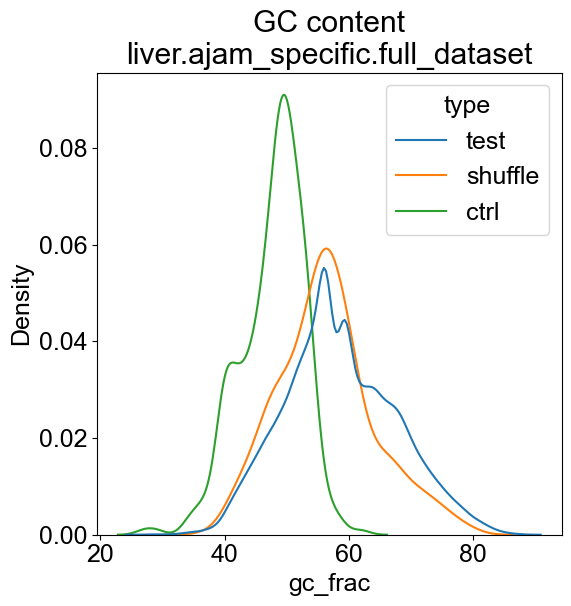

In [60]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.kdeplot(x="gc_frac",
            data=full_meta.loc[full_meta["dataset"].str.contains("forward")],
            hue="type", common_norm=False)

ax.set(title=f"GC content\n{TISSUE}.{SPECIES}_specific.full_dataset")

plt.savefig(os.path.join(
    PATH, f"{TISSUE}.{SPECIES}_specific.gc_content.full.pdf"), bbox_inches="tight")

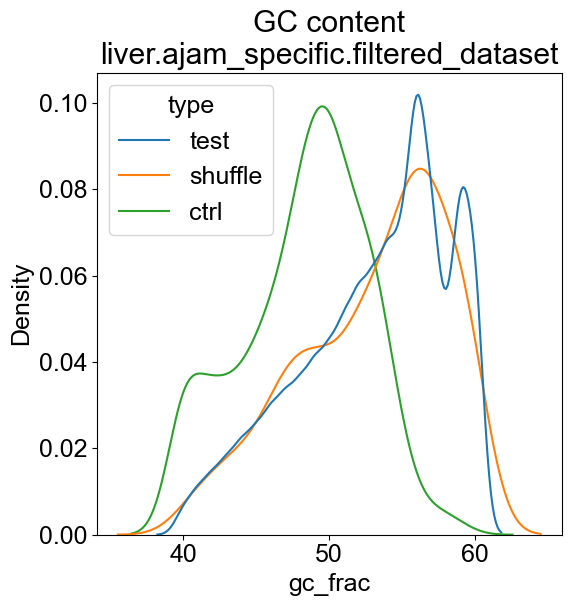

In [61]:
fig,ax=plt.subplots(figsize=(6,6))
sns.kdeplot(x="gc_frac", 
            data=full_meta.loc[
                (full_meta["dataset"].str.contains("forward"))
                &(full_meta["gc_within_40_60"]==True)
            ], 
            hue="type", common_norm=False)
ax.set(title=f"GC content\n{TISSUE}.{SPECIES}_specific.filtered_dataset")
plt.savefig(os.path.join(PATH, f"{TISSUE}.{SPECIES}_specific.gc_content.filtered.pdf"), bbox_inches="tight")

## evaluate how many positive and negative controls passed gc filter

In [67]:
gc_ctrls = full_meta.loc[
                (full_meta["dataset"].str.contains("forward.gcfiltered"))
                &(full_meta["gc_within_40_60"]==True)
    &(full_meta["type"]=="ctrl")].drop_duplicates()
gc_ctrls

coor  \
22567    Smith:HepG2Negative-0   
22568    Smith:HepG2Negative-1   
22569    Smith:HepG2Negative-2   
22570    Smith:HepG2Negative-3   
22571    Smith:HepG2Negative-4   
...                        ...   
22877  Smith:HepG2Positive-175   
22878  Smith:HepG2Positive-176   
22879  Smith:HepG2Positive-177   
22880  Smith:HepG2Positive-178   
22881  Smith:HepG2Positive-180   

                                                    info build  gc_frac  type  \
22567  C:SLEA_hg18:chr2:210861483-210861650|10:V_XBP1...  hg18       50  ctrl   
22568  C:SLEA_hg18:chr2:210861483-210861650|10:V_XBP1...  hg18       50  ctrl   
22569  C:SLEA_hg18:chr2:210861483-210861650|10:V_XBP1...  hg18       51  ctrl   
22570  C:SLEA_hg18:chr2:210861483-210861650|10:V_XBP1...  hg18       51  ctrl   
22571  C:SLEA_hg18:chr2:210861483-210861650|103:V_HNF...  hg18       42  ctrl   
...                                                  ...   ...      ...   ...   
22877  C:SLEA_hg18:chr9:82902419-82902586|6:V_Rxra_UP...  hg18       52  ctrl   
22878  C:SLEA_hg18:chr9:82902419-82902586|7:V_AHRARNT...  hg18       54  ctrl   
22879  C:SLEA_hg18:chr9:82902419-82902586|8:V_HNF4_Q6...  hg18       55  ctrl   
22880  C:SLEA_hg18:chr9:82902419-82902586|8:V_PPARA_0...  hg18       54  ctrl   
22881  R:FOXA2-ChMod_chr6:53480537-53480650_[chr6:534...  hg18       40  ctrl   

      strand                     dataset  gc_within_40_60  
22567      +  library_forward.gcfiltered             True  
22568      +  library_forward.gcfiltered             True  
22569      +  library_forward.gcfiltered             True  
22570      +  library_forward.gcfiltered             True  
22571      +  library_forward.gcfiltered             True  
...      ...                         ...              ...  
22877      +  library_forward.gcfiltered             True  
22878      +  library_forward.gcfiltered             True  
22879      +  library_forward.gcfiltered             True  
22880      +  library_forward.gcfiltered             True  
22881      +  library_forward.gcfiltered             True  

[315 rows x 8 columns]

In [68]:
gc_ctrls.loc[gc_ctrls["coor"].str.contains("Positive")].shape[0], gc_ctrls.loc[gc_ctrls["coor"].str.contains("Negative")].shape[0]

(172, 143)

### gc filtering HepG2 controls 
- N = 172 positive
- N = 143 negative

## median of GC filtered HepG2 controls is 49%

In [69]:
gc_ctrls.describe()

gc_frac
count  315.000000
mean    48.298413
std      4.284452
min     40.000000
25%     46.000000
50%     49.000000
75%     51.000000
max     59.000000

## median GC of filtered dataset is 54%

In [70]:
full_meta.loc[
                (full_meta["dataset"].str.contains("forward.gcfiltered"))
                &(full_meta["gc_within_40_60"]==True)].describe()

gc_frac
count  23182.000000
mean      52.837805
std        5.017876
min       40.000000
25%       49.000000
50%       54.000000
75%       57.000000
max       60.000000

## median GC of the full dataset is 61%

In [72]:
full_meta.loc[
                (full_meta["dataset"]==("library_forward"))].describe()

gc_frac
count  53348.000000
mean      60.886275
std        9.263192
min       27.000000
25%       55.000000
50%       61.000000
75%       67.000000
max       88.000000